In [1]:
import os
import time
from glob import glob

import cv2
import numpy as np
from matplotlib import pyplot as plt
from keras.models import load_model
from tqdm import tqdm

In [2]:
IMG_SIZE = (90, 90)
MODEL_PATH = "../data/model/"

In [3]:
def load_image(image_path, color=cv2.IMREAD_GRAYSCALE):
    image = cv2.imread(image_path, color)
    if image is None:
        raise FileNotFoundError(f"Image not found: {image_path}")

    return image


def show_image(img, cmap="gray"):
    plt.figure(figsize=(10, 10))
    plt.imshow(img, cmap=cmap)
    plt.axis("off")
    plt.show()


def show_image_with_contours(img, contours):
    contour_image = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)  # Convert to color for drawing
    cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)
    show_image(contour_image)


def filter_answer_boxes_by_size(contours, min_w=27, max_w=31, min_h=27, max_h=31):
    answer_box_contours = []

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)

        if min_w <= w <= max_w and min_h <= h <= max_h:
            answer_box_contours.append(contour)

    return answer_box_contours


def analyze_contour_sizes(contours):
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        print(f"Contour: width={w}, height={h}")


def extract_rectangles(image, rectangles, target_size=IMG_SIZE):
    extracted_rectangles = []
    target_h, target_w = target_size

    for rectangle in rectangles:
        x, y, w, h = cv2.boundingRect(rectangle)

        cropped_image = image[y:y + h, x:x + w]
        padded_image = np.ones((target_h, target_w), dtype=np.uint8) * 255

        scale = min(target_w / w, target_h / h)
        new_w = int(w * scale)
        new_h = int(h * scale)

        resized_image = cv2.resize(cropped_image, (new_w, new_h))

        start_x = (target_w - new_w) // 2
        start_y = (target_h - new_h) // 2

        padded_image[start_y:start_y + new_h, start_x:start_x + new_w] = resized_image
        extracted_rectangles.append(padded_image)

    return extracted_rectangles


def save_extracted_rectangles(extracted_rectangles, path_to_save):
    os.makedirs(path_to_save, exist_ok=True)
    timestamp = time.strftime("%d_%m_%Y_%H_%M_%S")
    for i, extracted_rectangle in enumerate(extracted_rectangles):
        cv2.imwrite(f"{path_to_save}/rectangle_{timestamp}_{i}.png", extracted_rectangle)


In [17]:
images_paths = glob("data/input/*.png")
for image_path in tqdm(images_paths):
    image = load_image(image_path, color=cv2.IMREAD_GRAYSCALE)
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
    adaptive_threshold = cv2.adaptiveThreshold(blurred_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                               cv2.THRESH_BINARY_INV, 11, 2)
    contours, _ = cv2.findContours(adaptive_threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    answer_box_contours = filter_answer_boxes_by_size(contours, min_w=60, max_w=100, min_h=60, max_h=100)
    extracted_rectangles = extract_rectangles(image, answer_box_contours)
    save_extracted_rectangles(extracted_rectangles, "data/output/test_dataset")


100%|██████████| 85/85 [00:15<00:00,  5.43it/s]


In [4]:
model = load_model(MODEL_PATH)
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Functiona  (None, 3, 3, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d_4   (None, 576)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 1)                 577       
                                                                 
Total params: 939,697
Trainable params: 927,585
Non-trainable params: 12,112
_________________________________________________________________


In [18]:
images_to_predict = glob("data/output/test_dataset/*.png")
print(f"Loaded {len(images_to_predict)} images")
for image_path in tqdm(images_to_predict):
    image = load_image(image_path, color=cv2.IMREAD_COLOR)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary_image = cv2.threshold(gray_image, 128, 255, cv2.THRESH_BINARY)
    binary_image_rgb = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2BGR)
    image = np.expand_dims(binary_image_rgb, axis=0)
    prediction = model.predict(image, verbose=0)
    predicted_label = prediction.round().flatten().astype(int)[0]
    os.makedirs(f"data/output/predictions/{predicted_label}", exist_ok=True)
    cv2.imwrite(f"data/output/predictions/{predicted_label}/{os.path.basename(image_path)}", cv2.imread(image_path))

Loaded 2496 images


100%|██████████| 2496/2496 [01:40<00:00, 24.76it/s]


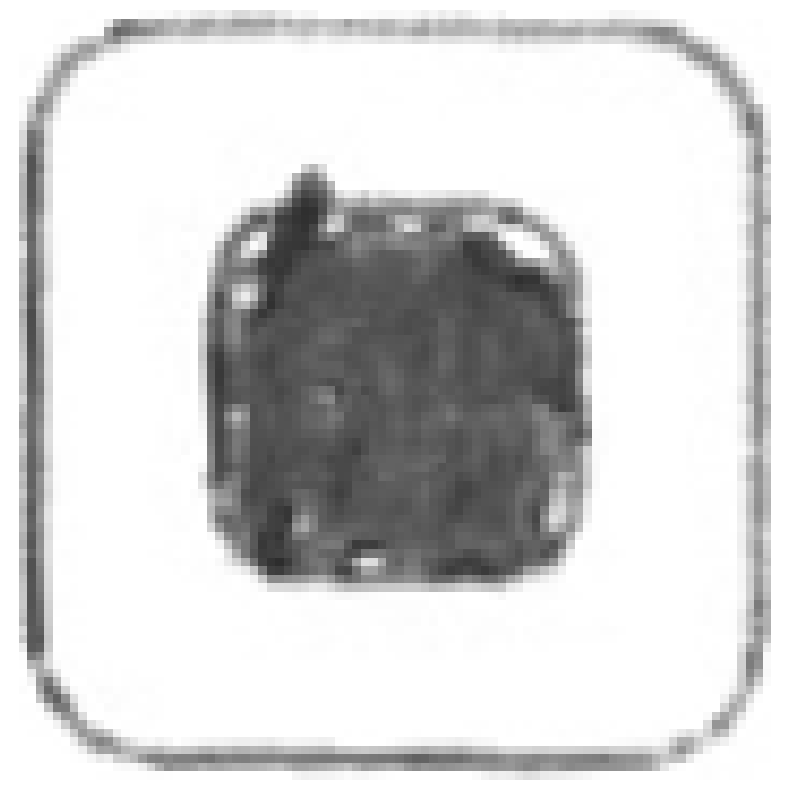

Image size: (90, 90, 3)
Predictions: [1.]


In [10]:
IMAGE_PATH = "data/output/test_dataset/rectangle_09_10_2024_22_43_06_1.png"
image = load_image(IMAGE_PATH, color=cv2.IMREAD_COLOR)
show_image(image)
print(f"Image size: {image.shape}")
model_input = np.expand_dims(image, axis=0)
prediction = model.predict(model_input, verbose=0)
predicted_label = prediction.round().flatten()
print(f"Predictions: {predicted_label}")

In [29]:
from keras.utils import image_dataset_from_directory
from sklearn.metrics import accuracy_score, precision_score, recall_score

BATCH_SIZE=256
TEST_DATASET_DIR = "data/output/test/"


test_dataset = image_dataset_from_directory(
    TEST_DATASET_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    label_mode='binary'
)
print(f"Dataset size: {len(test_dataset) * BATCH_SIZE}")

def preprocess_image(image):
    image = image.numpy()
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary_image = cv2.threshold(gray_image, 128, 255, cv2.THRESH_BINARY)
    binary_image_rgb = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2BGR)
    return binary_image_rgb

def preprocess_images(images):
    preprocessed_images = []
    for image in images:
        preprocessed_image = preprocess_image(image)
        preprocessed_image = np.expand_dims(preprocessed_image, axis=0)
        preprocessed_images.append(preprocessed_image)

    return np.vstack(preprocessed_images)

def evaluate_model(model, dataset, preprocess_image: bool):
    y_true = []
    y_pred = []
    for images, labels in dataset:
        model_input = preprocess_images(images) if preprocess_image else images
        predictions = model.predict(model_input, verbose=0)
        y_true.extend(labels.numpy())
        y_pred.extend(predictions.round().flatten())

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)

    return accuracy, precision, recall

# Evaluate the model on the test dataset
def print_metrics(accuracy, precision, recall, preprocess_image: bool):
    prefix = "Preprocessed" if preprocess_image else "Raw"
    print(f"[{prefix}] Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}")

t0 = time.perf_counter_ns()
accuracy, precision, recall = evaluate_model(model, test_dataset, False)
t1 = time.perf_counter_ns()
print_metrics(accuracy, precision, recall, False)
print(f"Time: {(t1 - t0) / 1e6} ms")

t0 = time.perf_counter_ns()
accuracy, precision, recall = evaluate_model(model, test_dataset, True)
t1 = time.perf_counter_ns()
print_metrics(accuracy, precision, recall, True)
print(f"Time: {(t1 - t0) / 1e6} ms")


Found 2496 files belonging to 2 classes.
Dataset size: 2560
[Raw] Accuracy: 0.9987980769230769, Precision: 1.0, Recall: 0.9964705882352941
Time: 2131.7675 ms
[Preprocessed] Accuracy: 1.0, Precision: 1.0, Recall: 1.0
Time: 2754.0748 ms
